In [169]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import idct

Variable initialization

In [170]:
N = 32 # signal dimension
M = 32 # number of atoms in the span (for basis M = N)

C = np.zeros((N, M)) # matrix containing the standard basis (a kronecker delta in each column)
D = np.zeros((N, M)) # matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

Text(0.5, 1.0, 'DCT basis')

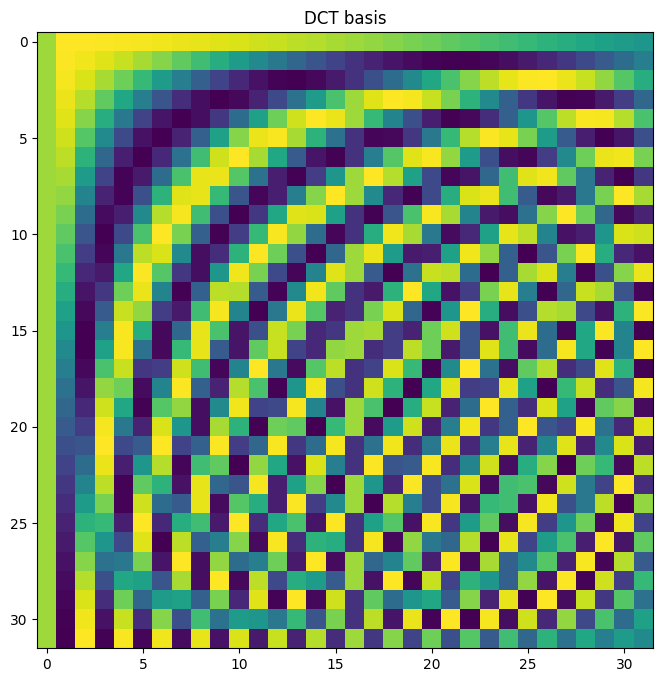

In [171]:
for i in range(M):
    a = np.zeros(N)
    a[i] = 1
    temp = np.reshape(idct(a),-1)
    norm = np.linalg.norm(temp)
    D[:, i] = temp/norm

plt.figure(figsize=(8,8))
plt.imshow(D)
plt.title('DCT basis')

In [172]:
is_D_orth = True
for i in range(M):
    for j in range(N):
        dot_product = D[:, i] @ D[:, j]
        if i != j:
            is_D_orth = np.isclose(dot_product, 0)
        else:
            is_D_orth = np.isclose(dot_product, 1)

        if(is_D_orth == False):
            break

print(f'DCT dictionary is orthogonal: {is_D_orth}')

DCT dictionary is orthogonal: True


# Sparsity w.r.t orthonormal dictionary D

In this section you will perform denoising of a signal that is *sparse* w.r.t. the orthornormal dictionary $D\in\mathbb{R}^{N\times N}$, i.e., the 1D-DCT dictionary.

At first, generate a vector $x_{orig}\in\mathbb{R}^N$ that is $L$-sparse, i.e. $\|x_{orig}\|_0 = L$. Use this coefficient vector $x_{orig}$, generate a noise-free signal $y\in\mathbb{R}^N$ as $y=Dx_{orig}$, and add some Gaussian noise to obtain $s = y + \eta$.

Perform the DCT denoising on the noisy signal $s$ to recover $\hat y$. Use the Hard Thresholding operator that keeps only the largest $L$ coefficients and evaluate the denoising performance


Set the sparsity level $L$

In [173]:
L = 3

Randomly define the coefficients of a sparse representation $x$ (make sure the nonzero coefficients are sufficiently large)

In [174]:
x_orig = np.zeros(M)
positions = np.random.choice(M, L, replace=False)
x_orig[positions] = np.random.rand(L)
x_orig

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.74794347, 0.        , 0.        ,
       0.        , 0.        , 0.04117454, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.98207325, 0.        , 0.        , 0.        ,
       0.        , 0.        ])

Synthetize the corresponding signal in the signal domain and add noise


In [175]:
#y=s0
y = D @ x_orig # noise free

sigma = 10/255
sigma_noise = sigma * (np.random.normal(size=y.shape))

# s = s0 + eta
s = y + sigma_noise

Plot the sparse signal

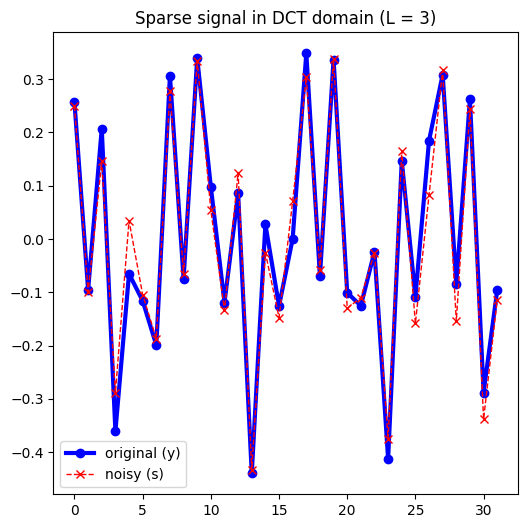

In [176]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6,6))
plt.plot(y, 'b-o', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original (y)', 'noisy (s)'])


### Implement the DCT denoising

This is expected to be very effective on $s$!

**Analysis**: compute the coefficients w.r.t. $D$

In [177]:
x = D.T @ s
print(x)

[-3.69724259e-02  7.62347752e-02 -2.37323852e-02  4.41890639e-02
 -1.84982748e-02 -4.04152439e-02 -1.60157692e-02  6.65393626e-01
 -1.20937437e-02 -3.52524167e-02 -2.26330313e-02  5.37966827e-02
  3.27380429e-02  1.08045169e-02  5.19127352e-02  4.93747467e-02
  9.62019742e-02 -2.39396202e-02 -2.81895713e-02  1.61680175e-02
  2.28715991e-02  1.64306769e-02 -7.38502291e-02 -9.07702862e-03
 -4.47915319e-04 -7.77188888e-02  9.60608647e-01 -1.26091021e-02
  3.18236015e-02 -5.50163059e-02  4.00611507e-02  6.62361495e-03]


**Hard Thresholding**: keep only the $L$ largest coefficients (absolute value)

In [178]:
x_copy = np.abs(x) # [3,1,2,-2,-5]
x_copy.sort() # [1,2,2,3,5]
gamma = x_copy[::-1][L-1] # [5,3,2,2,1] -> [2] if L = 3
x_hat = np.where(np.abs(x) < gamma, 0, x)
x_hat

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.66539363, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09620197, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.96060865, 0.        , 0.        , 0.        ,
       0.        , 0.        ])

**Synthesis**: invert the transform

In [179]:
s_hat = D @ x_hat

Plot the results:
- are the denoising performance good?
- are the original coefficients $x_{orig}$ recovered by $\hat x$?

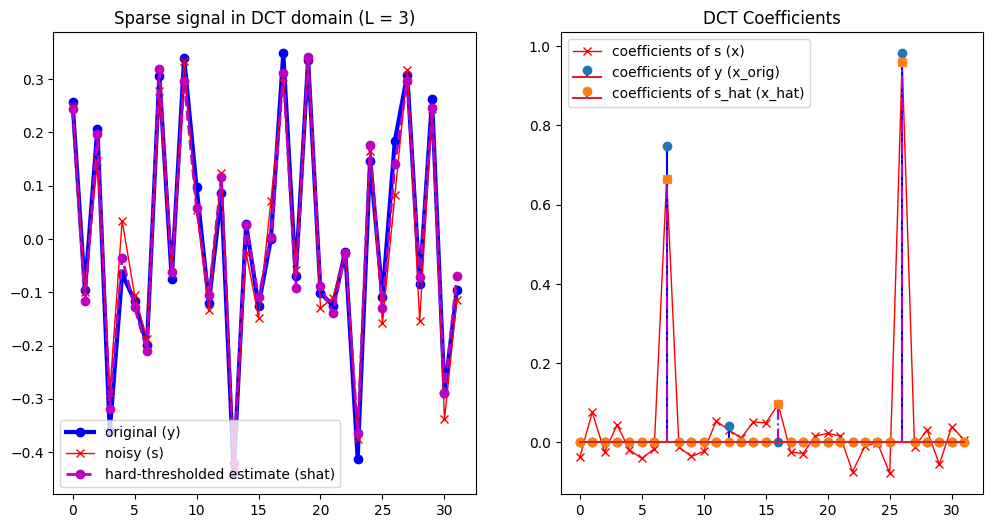

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(y, 'b-o', linewidth=LN_WDT+1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT-1)
ax[0].plot(s_hat, 'm--o', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'hard-thresholded estimate (shat)'])


ax[1].plot(x, 'r-x', linewidth=LN_WDT-1)
ax[1].stem(x_orig, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_hat, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s (x)', 'coefficients of y (x_orig)', 'coefficients of s_hat (x_hat)'])


# Sparsity w.r.t redoundant dictionary

In this section you will perform the same denoising as in the previous section with the only difference that the signal $s = y + \eta$ that you will generate is sparse w.r.t. a redoundant dictionary $A=[C, D] \in\mathbb{R}^{M \times N}$, where $C\in\mathbb{M\times M}$ is the matrix representity the canonical basis, and $D\in\mathbb{M\times M}$ is the usual 1D-DCT matrix. Therefore $A$ is a rectangular matrix, since $M < N$.

To generate signals that are sparse w.r.t. $A=[C, D]$, at first generate a signal $y$ that is $L-1$ sparse w.r.t. $D$ as you have done in the previous section. Then, add a spike to $y$ that is sparse w.r.t. $A$. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise.

Generate the standard orthonormal basis

Text(0.5, 1.0, 'Canonical basis dimension n = 32')

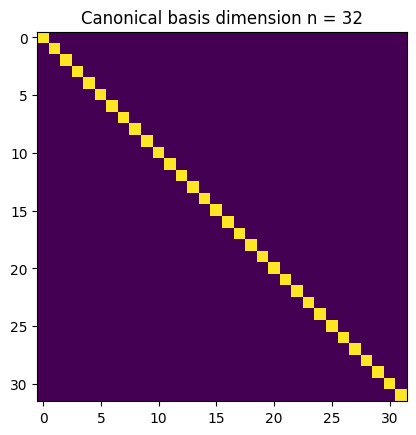

In [181]:
for i in range(M):
    a = np.zeros(M)
    a[i]=1
    C[:, i] = a

plt.figure(5)
plt.imshow(C)
plt.title(f'Canonical basis dimension n = {M}')



Generate a signal that is sparse w.r.t. D

In [182]:
x_orig = np.zeros(M)
positions = np.random.choice(M, L, replace=False)
x_orig[positions] = np.random.rand(L)

In [183]:
y = D @ x_orig # noise free
print(y)
np.abs(max(y))

[ 0.31083197 -0.18058492 -0.36435771  0.01453222  0.32338124  0.13630936
 -0.19884774 -0.22703177  0.02676795  0.23291696  0.14344908 -0.15680993
 -0.26479223  0.02744678  0.30736247  0.11059091 -0.26720052 -0.2118589
  0.16642647  0.24493425 -0.04481152 -0.20225989 -0.05424235  0.10175823
  0.09850559  0.02017312 -0.07749856 -0.12175978  0.00532576  0.17048446
  0.08508135 -0.15422236]


np.float64(0.32338123622658116)

Randomly place a spike in the first 20 samples of $y$


In [184]:
# choose spike location
spikeLocation = np.random.choice(20)
# modify the signal intensity at spikeLocation
# update y
lambda_spike = 4*np.abs(max(y))/y[spikeLocation] # this is to make the spike at least 4 times bigger than the biggest magnitude on signal
y[spikeLocation] = lambda_spike * y[spikeLocation]
print(y[spikeLocation])
print(spikeLocation)

1.2935249449063246
14


Add noise to the signal

In [185]:
sigma_noise = sigma * (np.random.normal(size=y.shape))

# s = s0 + eta
s = y + sigma_noise

Perform hard thresholding by keeping the largest $L$ coefficients w.r.t. $D$ (not $A$!)

In [186]:
# analysis: compute the coefficients w.r.t. D
x = D.T @ s

# keep only the L largest coefficients (absolute value)
x_copy = np.abs(x) # [3,1,2,-2,-5]
x_copy.sort() # [1,2,2,3,5]
gamma = x_copy[::-1][L-1] # [5,3,2,2,1] -> [2] if L = 3
x_hat = np.where(np.abs(x) < gamma, 0, x)

# invert the transformation
s_hat = D @ x_hat

Plot the results and compare them to the one obtained in the previous section.

Is the signal $s$ denoised properly?

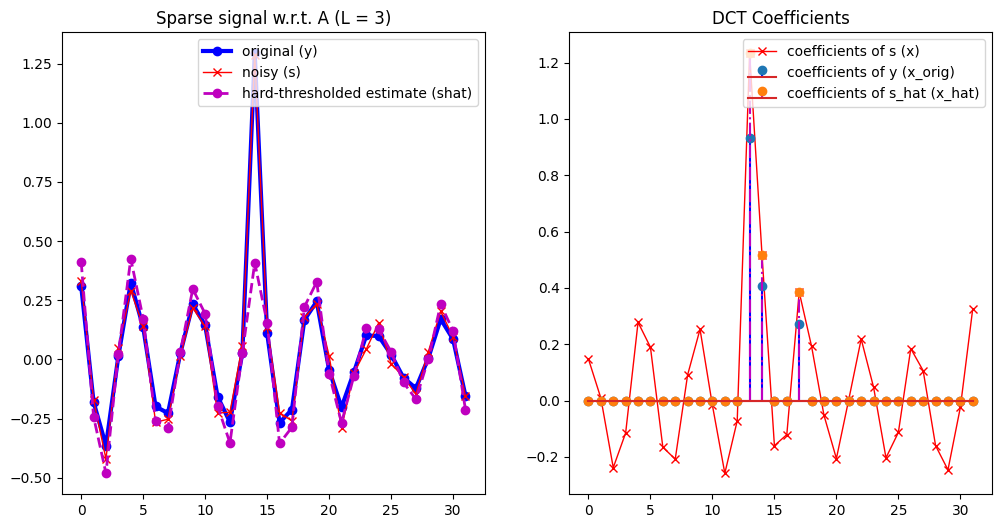

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(y, 'b-o', linewidth=LN_WDT+1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT-1)
ax[0].plot(s_hat, 'm--o', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t. A (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'hard-thresholded estimate (shat)'])


ax[1].plot(x, 'r-x', linewidth=LN_WDT-1)
ax[1].stem(x_orig, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_hat, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s (x)', 'coefficients of y (x_orig)', 'coefficients of s_hat (x_hat)'])

## Tichonov Regularization


Compute the representation w.r.t. $A = [C, D]$ using Tichonov's regularization (try differente value for $\lambda$)

Text(0.5, 1.0, 'Rectangular basis of dimension (32, 64)')

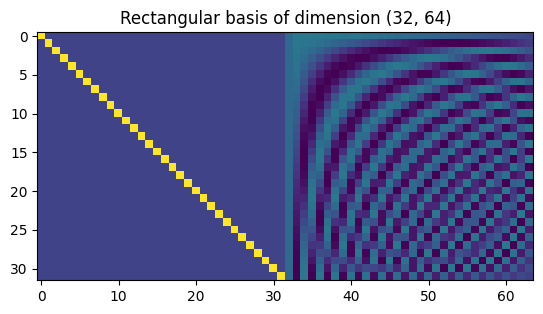

In [188]:
A = np.concatenate((C, D), axis=1)
plt.figure(5)
plt.imshow(A)
plt.title(f'Rectangular basis of dimension {A.shape}')

In [189]:
lmbda = 0.5 #1
den = np.linalg.inv((A.T @ A) + (lmbda*np.eye(64)))
x_hat_tic = A.T @ y @ den
s_hat_tic = A @ x_hat_tic

Show the results

Text(0.5, 1.0, 'Coefficients w.r.t. A')

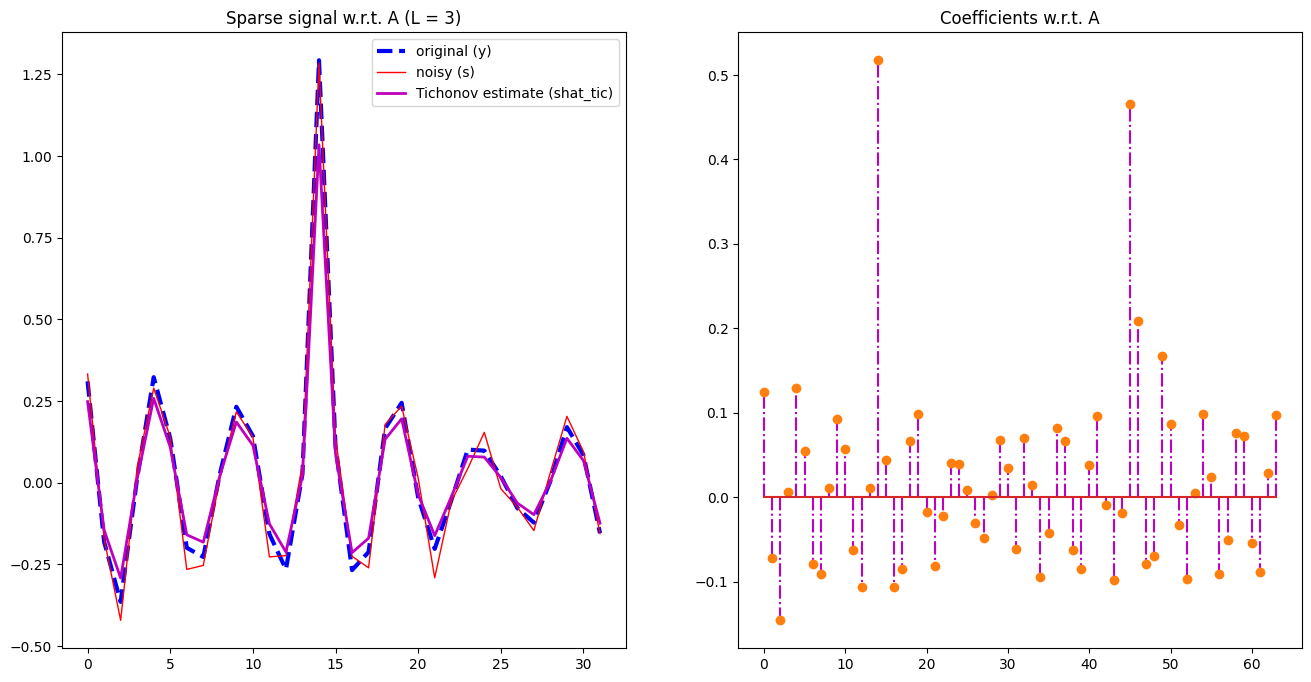

In [190]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(y, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_tic, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t. A (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'Tichonov estimate (shat_tic)'])

ax[1].stem(x_hat_tic, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients w.r.t. A')